### This script is for processing predictions from attacks to further analyze the results.

In [2]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import pickle
import csv
from tqdm import tqdm
import torch


# add ../.. to the path (MIAE)
import sys
sys.path.append('../../')
from miae.utils.dataset_utils import dataset_split
from experiment.models import get_model

COLUMNWIDTH = 241.14749
COLUMNWIDTH_INCH = 0.01384 * COLUMNWIDTH
TEXTWIDTH = 506.295
TEXTWIDTH_INCH = 0.01384 * TEXTWIDTH



In [3]:
"""select which task to perform"""
task = 2

### Task 1: Show training and testing accuracy for all target we have

In [4]:
import csv

pred_path = '/data/public/comp_mia_data/repeat_exp_set'
runs = [0, 1, 2, 3]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def accuracy(model, data, device):
    model.eval()
    correct = 0
    total = 0
    model.to(device)
    data_loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=False)
    with torch.inference_mode():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    top1_accuracy = correct / total
    _, top3_predicted = torch.topk(outputs.data, 3, dim=1)
    top3_correct = torch.sum(top3_predicted == labels.unsqueeze(1)).item()
    top3_accuracy = top3_correct / total
    return top1_accuracy, top3_accuracy


def process_accuracy(arch, dataset, runs):
    num_classes = 10 if dataset == "cifar10" else 100
    input_size = 32
    print (f"Number of classes: {num_classes}")
    if arch == "resnet56":
        target_model = get_model("resnet56", num_classes=num_classes, input_size=input_size)
    elif arch == "vgg16":
        target_model = get_model("vgg16", num_classes=num_classes, input_size=input_size)
    elif arch == "mobilenet":
        target_model = get_model("mobilenet", num_classes=num_classes, input_size=input_size)
    elif arch == "wrn32_4":
        target_model = get_model("wrn32_4", num_classes=num_classes, input_size=input_size)

    train_accuracies = []
    train_accuracies_top3 = []
    test_accuracies = []
    test_accuracies_top3 = []

    for run in runs:  
        target_path = os.path.join(pred_path, f"miae_experiment_aug_more_target_data_{run}/target")
        target_model_path = f"{target_path}/target_models/{dataset}/{arch}/target_model_{arch}{dataset}.pkl"
        target_train_data_path = f"{target_path}/{dataset}/target_trainset.pkl"
        target_test_data_path = f"{target_path}/{dataset}/target_testset.pkl"

        target_model.load_state_dict(torch.load(target_model_path))
        with open(target_train_data_path, 'rb') as f:
            target_train_data = pickle.load(f)
        with open(target_test_data_path, 'rb') as f:
            target_test_data = pickle.load(f)

        train_acc_ret = accuracy(target_model, target_train_data, device)
        test_acc_ret = accuracy(target_model, target_test_data, device)

        train_accuracies.append(train_acc_ret[0])
        train_accuracies_top3.append(train_acc_ret[1])
        test_accuracies.append(test_acc_ret[0])
        test_accuracies_top3.append(test_acc_ret[1])

    avg_train_accuracy = np.mean(train_accuracies)
    std_train_accuracy = np.std(train_accuracies)
    avg_train_accuracy_top3 = np.mean(train_accuracies_top3)
    std_train_accuracy_top3 = np.std(train_accuracies_top3)
    avg_test_accuracy = np.mean(test_accuracies)
    std_test_accuracy = np.std(test_accuracies)
    avg_test_accuracy_top3 = np.mean(test_accuracies_top3)
    std_test_accuracy_top3 = np.std(test_accuracies_top3)
    generalization_gap = avg_train_accuracy - avg_test_accuracy
    generalization_gap_std = std_train_accuracy - std_test_accuracy


    # average accuracy, std
    print(f"Average train accuracy: {avg_train_accuracy*100:.4f}% ± {std_train_accuracy*100:.4f}%")
    print(f"Average test accuracy: {avg_test_accuracy*100:.4f}% ± {std_test_accuracy*100:.4f}%")
    print(f"Generalization gap: {generalization_gap*100:.4f}% ± {generalization_gap_std*100:.4f}%")

    return avg_train_accuracy, std_train_accuracy, avg_train_accuracy_top3, std_train_accuracy_top3, avg_test_accuracy, std_test_accuracy, avg_test_accuracy_top3, std_test_accuracy_top3, generalization_gap, generalization_gap_std

arch_list = ["resnet56", "vgg16", "mobilenet", "wrn32_4"]
dataset_list = ["cifar10", "cifar100"]

header = ['Architecture', 'Dataset', 'Avg Train Accuracy', 'Std Train Accuracy', 'Avg Test Accuracy', 'Std Test Accuracy', 'Generalization Gap', 'Generalization Gap Std']
if task == 1:
    with open(save_path, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)

    for arch in arch_list:
        for dataset in dataset_list:
            print(f"Processing {arch} on {dataset}")
            avg_train_accuracy, std_train_accuracy, avg_train_accuracy_top3, std_train_accuracy_top3, avg_test_accuracy, std_test_accuracy, avg_test_accuracy_top3, std_test_accuracy_top3, generalization_gap, generalization_gap_std = process_accuracy(arch, dataset, runs)
            
            # save to csv
            save_path = f"{pred_path}/target_training_statsd.csv"
            with open(save_path, mode='a') as f:
                writer = csv.writer(f)
                writer.writerow([arch, dataset, avg_train_accuracy, std_train_accuracy, avg_test_accuracy, std_test_accuracy, generalization_gap, generalization_gap_std])
    print(f"csv saved to {save_path}/miae_experiment_aug_more_target_data/target_training_statsd.csv")

### Task 2: loss distribution

Target loss loaded from /data/public/comp_mia_data/miae_experiment_aug_more_target_data/target/target_loss.npy


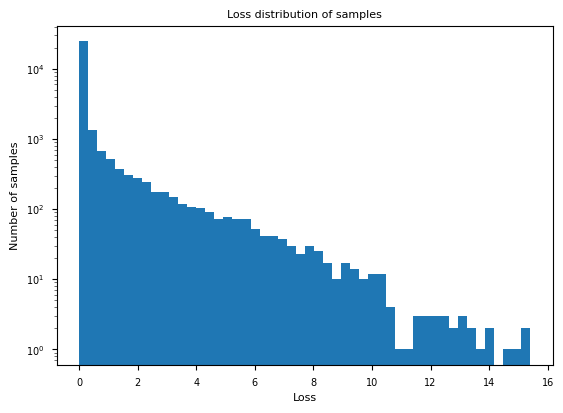

mia_tp_loss.tex saved at /home/wangz56/MIAE/experiment/mia_comp
mia_tn_loss.tex saved at /home/wangz56/MIAE/experiment/mia_comp


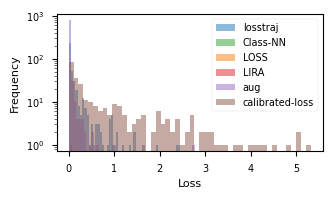

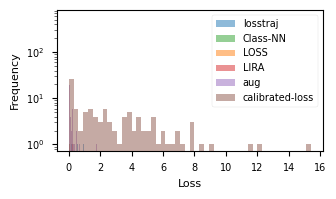

In [6]:
dataset = "cifar10"
model = "resnet56"
pred_path = '/data/public/comp_mia_data/miae_experiment_aug_more_target_data'
target_data_path = '/data/public/comp_mia_data/miae_experiment_aug_more_target_data/target/cifar10'
mias = ["losstraj", "shokri", "yeom", "lira", "aug", "calibration"]
mia_name_mapping = {"losstraj": "losstraj", "shokri": "Class-NN", "yeom": "LOSS", "lira": "LIRA", "aug": "aug", "calibration": "calibrated-loss"}
seeds = [0, 1, 2, 3 ,4, 5]
device = torch.device("cuda:0")
fpr = 0.1

from experiment.models import get_model
from typing import Dict, List
from miae.eval_methods.prediction import Predictions
import matplotlib as mpl

plt.style.use('seaborn-v0_8-paper')
# set fontsize
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('legend', fontsize=7)
plt.rc('font', size=7)       
plt.rc('axes', titlesize=8)    
plt.rc('axes', labelsize=8)

def get_loss(model, data, device) -> np.array:
    """
    Get the loss of the model on each data point
    """
    model.eval()
    model.to(device)
    data_loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False)
    loss_array = []
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = torch.nn.CrossEntropyLoss()(outputs, labels)
            loss_array.append(loss.item())
    return np.array(loss_array)

def mia_pred_unique1(pred_dict: Dict[str, np.array]) -> dict[np.array]:
    """
    Get the unique prediction of the MIA
    """
    unique_pred_dict = dict()
    for i in (pred_dict.keys()):
        pred_i = pred_dict[i]
        other_attack_pred = np.zeros_like(pred_i)
        for j in pred_dict.keys():  # iterate over all other attacks
            if j != i:
                np.logical_or(other_attack_pred, pred_dict[j], out=other_attack_pred)
        
        # unique_pred = pred_i and not other_attack_pred
        unique_pred = np.logical_and(pred_i, np.logical_not(other_attack_pred))
        unique_pred_dict[i] = unique_pred

    return unique_pred_dict


# -- loading membership prediction and ground truth

with open(f"{target_data_path}/attack_set_membership.npy", 'rb') as f:
    gt = np.load(f)

if task == 2:
    mia_pred_dict = {} # prediction of different MIA
    for mia in mias:
        mia_pred_dict[mia] = {}
        for seed in seeds:
            with open(f"{pred_path}/preds_sd{seed}/{dataset}/{model}/{mia}/pred_{mia}.npy", 'rb') as f:
                mia_pred = np.load(f)
            mia_pred_dict[mia][seed] = Predictions(mia_pred, gt, f"{mia}_sd{seed}").adjust_fpr(fpr)

    mia_pred_TP = {} # true positive of different MIA
    for mia in mias:
        mia_pred_TP[mia] = {}
        for seed in seeds: # mia_pred_TP[mia][seed][i] == 1 means the i-th data point is correctly predicted as a member
            mia_pred_TP[mia][seed] = np.array(mia_pred_dict[mia][seed]) == gt

    mia_pred_TN = {} # true negative of different MIA
    for mia in mias:
        mia_pred_TN[mia] = {}
        for seed in seeds: # mia_pred_TN[mia][seed][i] == 1 means the i-th data point is correctly predicted as a non-member
            mia_pred_TN[mia][seed] = np.array(mia_pred_dict[mia][seed]) != gt

    mia_pred_TP_intersection = {} # intersection of TP of each MIA across different seeds
    for mia in mias:
        mia_pred_TP_intersection[mia] = np.array([mia_pred_TP[mia][seed] for seed in seeds]).all(axis=0)

    mia_pred_TN_intersection = {} # intersection of TN of each MIA across different seeds
    for mia in mias:
        mia_pred_TN_intersection[mia] = np.array([mia_pred_TN[mia][seed] for seed in seeds]).all(axis=0)

    # -- loading target data and target model
    with open(f"{target_data_path}/target_trainset.pkl", 'rb') as f:
        target_train_data = pickle.load(f)

    with open(f"{target_data_path}/target_testset.pkl", 'rb') as f:
        target_test_data = pickle.load(f)

    target_model = get_model(model, num_classes=10, input_size=32)
    target_model.load_state_dict(torch.load(f"{pred_path}/target/target_models/{dataset}/{model}/target_model_{model}{dataset}.pkl"))

    # -- get the loss of the target model on the target data
    if not os.path.exists(f"{pred_path}/target/target_loss.npy"):
        print(f"no target loss found at {pred_path}/target/target_loss.npy, calculating...")
        target_train_loss = get_loss(target_model, target_train_data, device)
        target_test_loss = get_loss(target_model, target_test_data, device)
        target_loss = np.concatenate([target_train_loss, target_test_loss])
        with open(f"{pred_path}/target/target_loss.npy", 'wb') as f:
            np.save(f, target_loss)
        print(f"Target loss saved to {pred_path}/target/target_loss.npy")
    else:
        with open(f"{pred_path}/target/target_loss.npy", 'rb') as f:
            target_loss = np.load(f)
        print(f"Target loss loaded from {pred_path}/target/target_loss.npy")

    # -- show loss distribution of samples
    plt.hist(target_loss, bins=50)
    plt.xlabel('Loss')
    plt.ylabel('Number of samples')
    plt.title('Loss distribution of samples')
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.show()

    # -- get the TP and TN from different attacks
    mia_pred_TP_intersection_unique = mia_pred_unique1(mia_pred_TP_intersection)
    mia_pred_TN_intersection_unique = mia_pred_unique1(mia_pred_TN_intersection)


    # -- plot the number of TP at different loss values. Each attack is a different color
    plt.figure(figsize=(COLUMNWIDTH_INCH, 2))
    colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728', '#9467bd', '#8c564b']
    for I, mia in enumerate(mias):
        plt.hist(target_loss[mia_pred_TP_intersection_unique[mia]], bins=50, alpha=0.5, color=colors[I], label=mia_name_mapping[mia])

    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    plt.legend()
    plt.yscale('log')
    plt.tight_layout()
    # save to pdf
    plt.savefig(f"loss_vs_tp_fpr0.1_no_cali.pdf", format='pdf')
    print(f"mia_tp_loss.tex saved at {os.getcwd()}")

    # -- plot the number of TN at different loss values. Each attack is a different color
    plt.figure(figsize=(COLUMNWIDTH_INCH, 2))
    colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728', '#9467bd', '#8c564b']
    for I, mia in enumerate(mias):
        plt.hist(target_loss[mia_pred_TN_intersection_unique[mia]], bins=50, alpha=0.5, color=colors[I], label=mia_name_mapping[mia])

    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    plt.legend()
    plt.yscale('log')
    plt.tight_layout()
    # save to pdf
    plt.savefig(f"loss_vs_tn_fpr0.1_no_cali.pdf", format='pdf')
    print(f"mia_tn_loss.tex saved at {os.getcwd()}")